<a href="https://colab.research.google.com/github/sarnavadatta/Finance-in-Python/blob/main/StockPricePrediction_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Restart session after this runnung this cell

!pip install --upgrade pip  # Good practice to update pip first
!pip uninstall numpy -y # Uninstall existing numpy
!pip install numpy==1.26.4 # Install a compatible numpy version
!pip install pmdarima # Install pmdarima after fixing numpy
!pip install yfinance # Ensure yfinance is installed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 182.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
print(f"NumPy Version after downgrade: {np.__version__}")

NumPy Version after downgrade: 1.26.4


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore') # Ignore warnings

In [ ]:
ticker = "TATAMOTORS.NS"
start_date = "2022-01-01"
end_date = "2025-06-19"

print(f"Fetching data for {ticker} from {start_date} to {end_date}...")
stock = yf.download(ticker, start=start_date, end=end_date)

if stock.empty:
    print(f"No data fetched for {ticker}. Please check the ticker symbol or date range.")
else:
    print("Data fetched successfully!")
    #print(stock.head())

[*********************100%***********************]  1 of 1 completed

Fetching data for TATAMOTORS.NS from 2022-01-01 to 2025-06-19...
Data fetched successfully!


In [ ]:
df=pd.DataFrame()
df['Close']=pd.to_numeric(np.log(stock.iloc[:,0]))
# df['Open']=pd.to_numeric(stock.iloc[:,1])
# df['High']=pd.to_numeric(stock.iloc[:,2])
# df['Low']=pd.to_numeric(stock.iloc[:,3])
# df['Volume']=pd.to_numeric(stock.iloc[:,4])
df

,Close
Date,
2022-01-03,6.195043
2022-01-04,6.178835
2022-01-05,6.179141
2022-01-06,6.177302
2022-01-07,6.180875
...,...
2025-06-12,6.572772
2025-06-13,6.568148
2025-06-16,6.531825


In [ ]:
df.isnull().any()

,0
Close,False


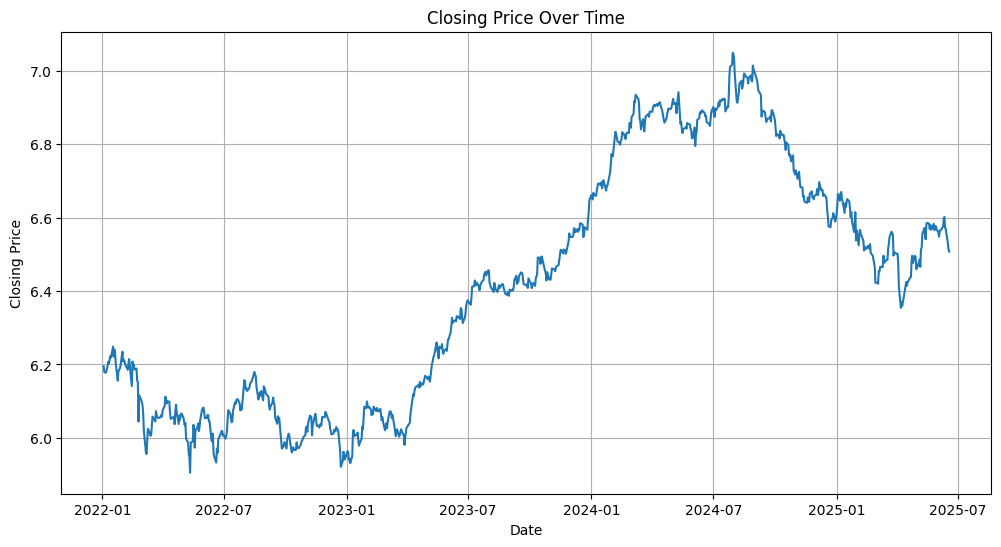

In [ ]:
# plot the closing price

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'])
plt.title('Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.grid(True)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string()) # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [ ]:
adf_test(df['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.973336
p-value                   0.762865
# lags used               0.000000
# observations          853.000000
critical value (1%)      -3.438039
critical value (5%)      -2.864934
critical value (10%)     -2.568577
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


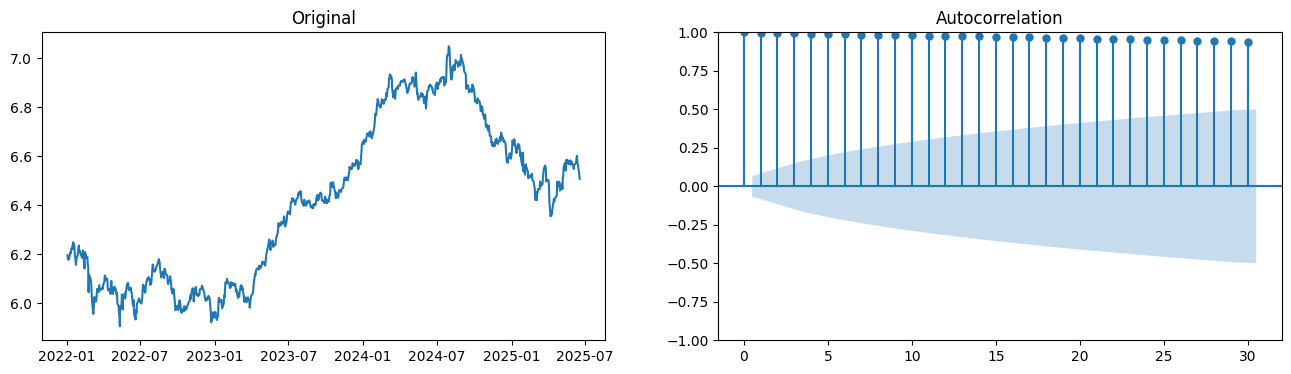

In [ ]:
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize=(16,4))

ax1.plot(df['Close'])
ax1.set_title('Original')
plot_acf(df['Close'], ax=ax2);

In [ ]:
diff_first = df['Close'].diff().dropna()
adf_test(diff_first)

Augmented Dickey-Fuller Test: 
ADF test statistic      -29.490262
p-value                   0.000000
# lags used               0.000000
# observations          852.000000
critical value (1%)      -3.438048
critical value (5%)      -2.864938
critical value (10%)     -2.568580
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


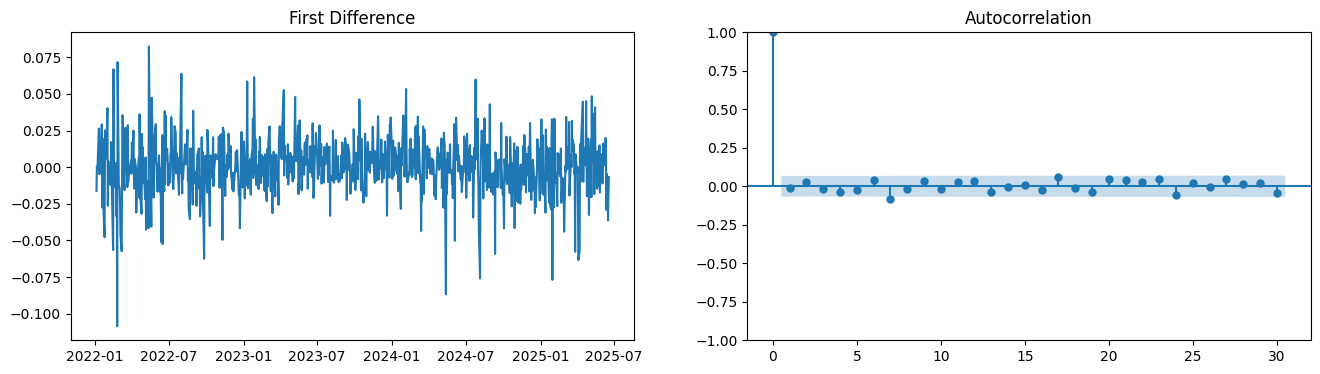

In [ ]:
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize=(16,4))

ax1.plot(diff_first)
ax1.set_title('First Difference')
plot_acf(diff_first, ax=ax2);

In [ ]:
diff_second = df['Close'].diff().diff().dropna()
adf_test(diff_second)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.164395e+01
p-value                 2.114167e-21
# lags used             2.100000e+01
# observations          8.300000e+02
critical value (1%)    -3.438253e+00
critical value (5%)    -2.865029e+00
critical value (10%)   -2.568628e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


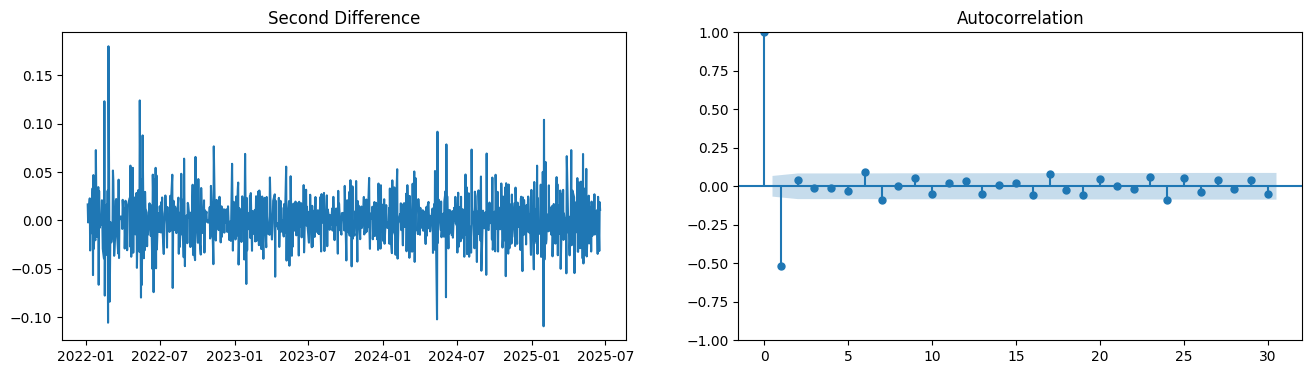

In [ ]:
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize=(16,4))

ax1.plot(diff_second)
ax1.set_title('Second Difference')
plot_acf(diff_second, ax=ax2);

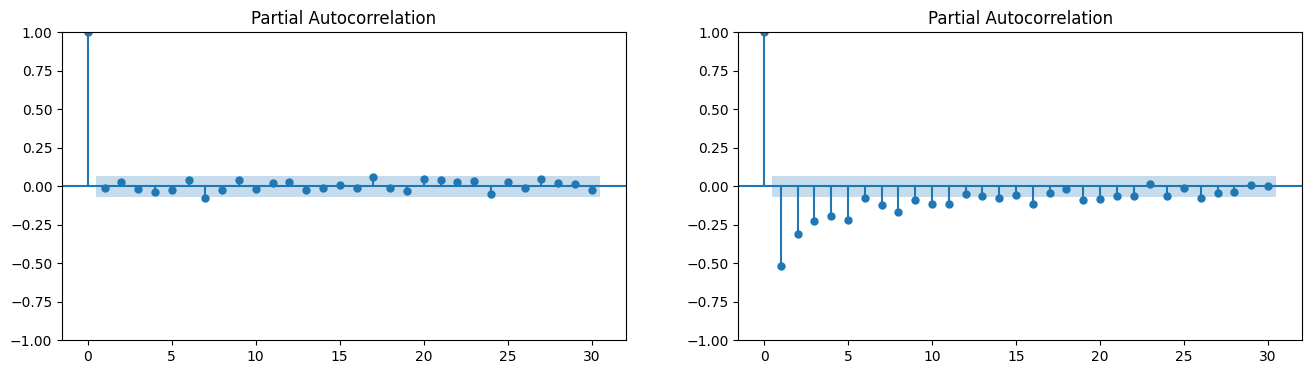

In [ ]:
fig, (ax1, ax2) = plt.subplots(1 , 2, figsize=(16,4))
plot_pacf(diff_first, ax=ax1);
plot_pacf(diff_second, ax=ax2);

In [ ]:
# Train-Test Split
train_size = int(len(df) * 0.85)
train, test = df[:train_size], df[train_size:]

In [ ]:
# --- Automated ARIMA/SARIMA order selection using pmdarima ---
print("\n--- Using auto_arima to find optimal ARIMA order ---")

model_auto_arima = pm.auto_arima(train['Close'],
                                start_p=1, start_q=1,
                                max_p=8, max_q=8,
                                d=None, # Let auto_arima determine differencing order
                                trace=True, # Show fitting process
                                suppress_warnings=True,
                                stepwise=False, # Try all combinations (more thorough, but slower)
                                seasonal=False) # Start with non-seasonal ARIMA

print(f"\nOptimal ARIMA Order (p,d,q) found by auto_arima: {model_auto_arima.order}")


--- Using auto_arima to find optimal ARIMA order ---
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3679.108, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3677.284, Time=0.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-3675.566, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-3675.558, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-3673.829, Time=0.51 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-3671.957, Time=0.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3677.291, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3675.288, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-3673.950, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-3673.696, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-3671.635, Time=0.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-3675.608, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-3673.596, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3672.789, Time=0.53 sec
 ARIMA(2

In [ ]:
p,d,q = model_auto_arima.order

In [ ]:
print(f"\n--- Fitting ARIMA({p},{d},{q}) model to training data ---")
arima_model = ARIMA(train['Close'], order=(p, d, q))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# --- 5. Forecast on the test data ---
print("\n--- Forecasting on the test data ---")

# forecast() is the recommended method for out-of-sample forecasting in newer statsmodels
forecast_result = arima_model_fit.forecast(steps=len(test))

#predictions = pd.Series(forecast_result.values, index=test.index)


--- Fitting ARIMA(0,1,0) model to training data ---
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  725
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1841.113
Date:                Fri, 20 Jun 2025   AIC                          -3680.225
Time:                        11:42:56   BIC                          -3675.640
Sample:                             0   HQIC                         -3678.456
                                - 725                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   1.15e-05     31.453      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               3

In [ ]:
# Make dataframe with the values of forecast result & and the index of test

forecast_df = pd.DataFrame({'Forecast': forecast_result.values}, index=test.index)
print("\nForecast Results with Test Set Index:")
forecast_df


Forecast Results with Test Set Index:


,Forecast
Date,
2024-12-11,6.675926
2024-12-12,6.675926
2024-12-13,6.675926
2024-12-16,6.675926
2024-12-17,6.675926
...,...
2025-06-12,6.675926
2025-06-13,6.675926
2025-06-16,6.675926


In [ ]:
# plt.figure(figsize=(12, 6))
# plt.plot(test.index, test['Close'], label='Actual Test Set', color='blue')
# plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
# plt.title('Forecast vs Actual Test Set')
# plt.xlabel('Date')
# plt.ylabel('Closing Price')
# plt.xticks(rotation=45, ha='right') # Tilt x-axis labels
# plt.legend()
# plt.grid(True)
# plt.tight_layout() # Adjust layout to prevent labels overlapping
# plt.show()

In [ ]:
# Convert the log-transformed forecasts back to the original scale
forecast_original_scale = np.exp(forecast_df['Forecast'])
actual_test_original_scale = np.exp(test['Close'])

# Calculate performance metrics in the original scale (optional but recommended)
rmse_original_scale = np.sqrt(mean_squared_error(actual_test_original_scale, forecast_original_scale))
print(f"\nRMSE on Original Scale: {rmse_original_scale}")


RMSE on Original Scale: 109.38830474978315


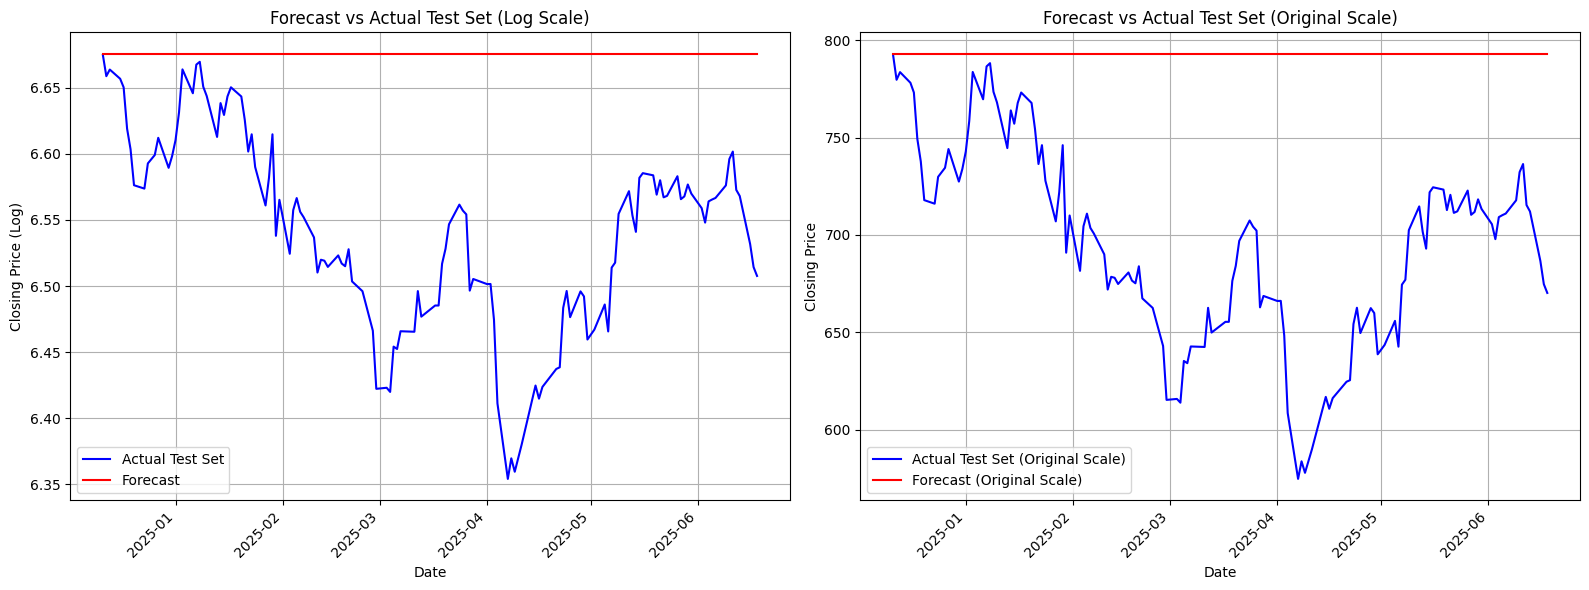

In [ ]:
# prompt: put last two graphs side by side

plt.figure(figsize=(16, 6)) # Adjust the overall figure size if needed

plt.subplot(1, 2, 1) # Create the first subplot (1 row, 2 columns, 1st plot)
plt.plot(test.index, test['Close'], label='Actual Test Set', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.title('Forecast vs Actual Test Set (Log Scale)') # Add title
plt.xlabel('Date')
plt.ylabel('Closing Price (Log)') # Adjust ylabel
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # Create the second subplot (1 row, 2 columns, 2nd plot)
plt.plot(actual_test_original_scale.index, actual_test_original_scale, label='Actual Test Set (Original Scale)', color='blue')
plt.plot(forecast_original_scale.index, forecast_original_scale, label='Forecast (Original Scale)', color='red')
plt.title('Forecast vs Actual Test Set (Original Scale)') # Add title
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)

plt.tight_layout() # Adjust layout to prevent overlap
plt.show()


--- Fitting ARIMA(0,1,0) model to training data ---
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  725
Model:                 ARIMA(0, 1, 0)   Log Likelihood                1841.113
Date:                Fri, 20 Jun 2025   AIC                          -3680.225
Time:                        11:58:44   BIC                          -3675.640
Sample:                             0   HQIC                         -3678.456
                                - 725                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   1.15e-05     31.453      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):               3

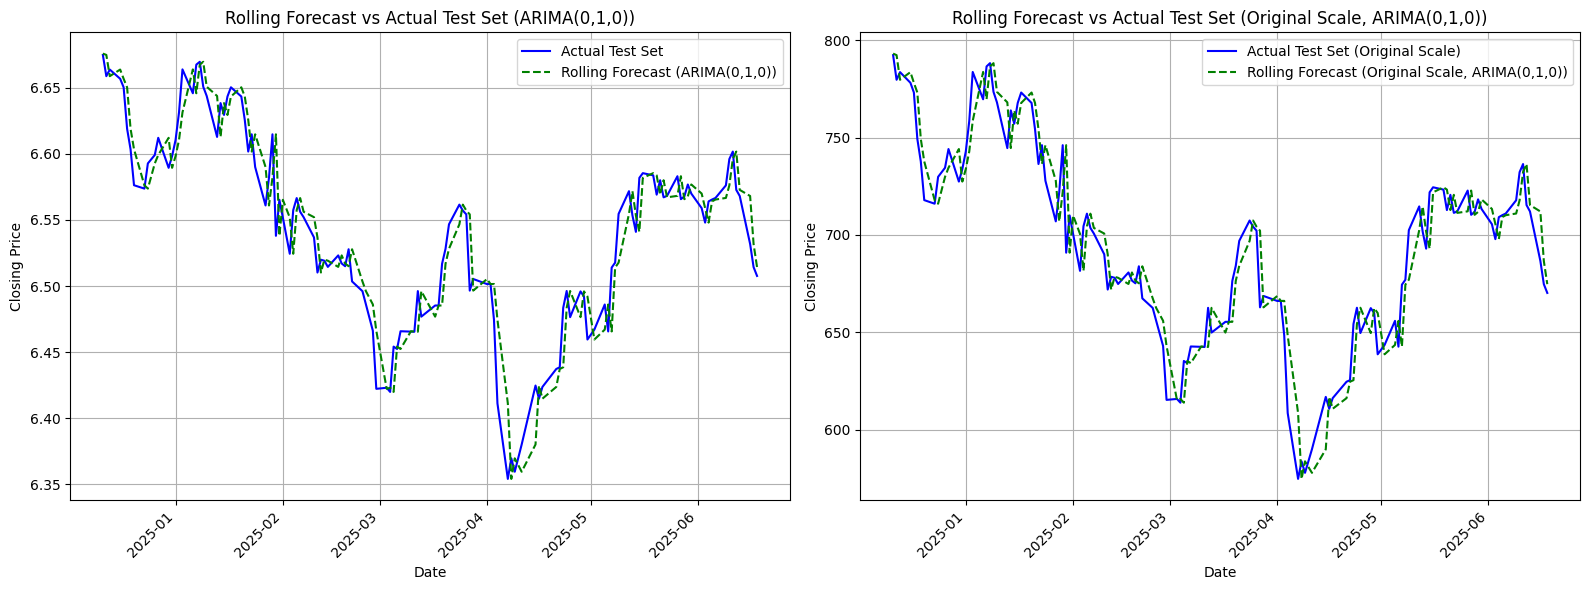


RMSE for Rolling Forecast on Original Scale (ARIMA(0,1,0)): 14.817844964958201


In [ ]:
# Fit the ARIMA({p},{d},{q}). Use rolling forcast prediction.
# A rolling forecast prediction is a method of forecasting that continually updates and extends the forecast period as time progresses.

print(f"\n--- Fitting ARIMA({p},{d},{q}) model to training data ---")
arima_model = ARIMA(train['Close'], order=(p, d, q))
arima_model_fit = arima_model.fit()
print(arima_model_fit.summary())

# --- Rolling Forecast Prediction ---
history = [x for x in train['Close']]
predictions = []
# Define the size of the rolling window, here it's the size of the test set
window_size = len(test)

print(f"\nPerforming rolling forecast with window size: {window_size}")

# Iterate through the test set indices
for t in range(window_size):
    # Fit the ARIMA model on the historical data
    model = ARIMA(history, order=(p, d, q))
    model_fit = model.fit()

    # Make a one-step forecast
    output = model_fit.forecast(steps=1)
    yhat = output[0]
    predictions.append(yhat)

    # Get the actual observation for the current step
    obs = test['Close'].iloc[t]

    # Append the actual observation to history for the next iteration
    history.append(obs)

    # Print progress
    # print(f'predicted={yhat}, expected={obs}')

# Convert predictions to a pandas Series with the test set index
rolling_predictions_df = pd.DataFrame({'Rolling_Forecast': predictions}, index=test.index)

print("\nRolling Forecast Results with Test Set Index:")
print(rolling_predictions_df.head())


# Convert rolling forecasts back to original scale
rolling_forecast_original_scale = np.exp(rolling_predictions_df['Rolling_Forecast'])


# Plot the rolling forecast vs actual test set
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1) # Create the first subplot (1 row, 2 columns, 1st plot)
plt.plot(test.index, test['Close'], label='Actual Test Set', color='blue')
plt.plot(rolling_predictions_df.index, rolling_predictions_df['Rolling_Forecast'], label=f'Rolling Forecast (ARIMA({p},{d},{q}))', color='green', linestyle='--')
plt.title(f'Rolling Forecast vs Actual Test Set (ARIMA({p},{d},{q}))')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)



# Plot rolling forecast vs actual test set in original scale
plt.subplot(1, 2, 2) # Create the second subplot (1 row, 2 columns, 2nd plot)
plt.plot(actual_test_original_scale.index, actual_test_original_scale, label='Actual Test Set (Original Scale)', color='blue')
plt.plot(rolling_forecast_original_scale.index, rolling_forecast_original_scale, label=f'Rolling Forecast (Original Scale, ARIMA({p},{d},{q}))', color='green', linestyle='--')
plt.title(f'Rolling Forecast vs Actual Test Set (Original Scale, ARIMA({p},{d},{q}))')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


# Calculate performance metrics for the rolling forecast in the original scale
rmse_rolling_original_scale = np.sqrt(mean_squared_error(actual_test_original_scale, rolling_forecast_original_scale))
print(f"\nRMSE for Rolling Forecast on Original Scale (ARIMA({p},{d},{q})): {rmse_rolling_original_scale}")

